## VQE ansatz: 001

In [1]:
import os
import numpy


import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer


import sys
sys.path.append("..")
from wordsToNumbers import Corpus
from wordsToNumbers import fibonacci_vocabulary

from wordsToQubits import put_word_on_sphere

from utils import get_corpus_from_directory, working_window, get_word_from_sphere

In [2]:
np.random.seed(73)

## Corpus

In [3]:
corpus_path='/Users/voicutu/Documents/GitHub/Qountry/Bebe'

corpus_tex = get_corpus_from_directory(corpus_path, limit=1)

corpus= Corpus(corpus_tex)
print(corpus.prop())

nr. words:72 
nr. distinct words: 8 
len.text/len.vocab:9.0


In [4]:
parameterize_vovabulary = fibonacci_vocabulary(corpus.vocabulary)

In [5]:
print("corpus:",corpus.split_text)

corpus: ['ursul', 'are', 'bot', 'punct', 'cainele', 'are', 'bot', 'punct', 'ursul', 'este', 'fericit', 'punct', 'cainele', 'este', 'fericit', 'punct', 'cainele', 'este', 'frumos', 'punct', 'cainele', 'are', 'bot', 'frumos', 'punct', 'cainele', 'frumos', 'are', 'bot', 'punct', 'ursul', 'frumos', 'are', 'bot', 'punct', 'ursul', 'fericit', 'are', 'bot', 'punct', 'ursul', 'fericit', 'are', 'bot', 'frumos', 'punct', 'cainele', 'frumos', 'are', 'bot', 'frumos', 'punct', 'ursul', 'frumos', 'are', 'bot', 'punct', 'ursul', 'frumos', 'este', 'fericit', 'punct', 'cainele', 'fericit', 'este', 'frumos', 'punct', 'ursul', 'fericit', 'este', 'frumos', 'punct']


## Training set 

In [6]:
history_lenghth = 3

In [7]:
x,y = working_window(history_lenghth, splited_text=corpus.split_text)

In [8]:
print("len training set:", len(x))

len training set: 68


## Circuit

In [9]:
dev = qml.device("default.qubit", wires=history_lenghth+1)

# circuit initializer
def circuit_initializer(words):
    for i in range(len(words)):
        put_word_on_sphere(words[i], qubit=i)

In [10]:
def layer_type1(param, wires=[0,1,2]):

    qml.CRZ( param[0], wires=[0,1])
    qml.CRX( param[1], wires=[0,1])
    qml.CRY( param[2], wires=[0,1])

    qml.CRZ( param[3], wires=[1,2])
    qml.CRX( param[4], wires=[1,2])
    qml.CRY( param[5], wires=[1,2])

    qml.CRZ( param[6], wires=[2,3])
    qml.CRX( param[7], wires=[2,3])
    qml.CRY( param[8], wires=[2,3])

    qml.RX( param[9], wires=0)
    qml.RY( param[10], wires=0)

    qml.RX( param[11], wires=1)
    qml.RY( param[12], wires=1)

    qml.RX( param[13], wires=2)
    qml.RY( param[14], wires=2)

    qml.RX( param[15], wires=3)
    qml.RY( param[16], wires=3)


In [11]:
@qml.qnode(dev)
def next_gen(params, x, obs='z'):
    """
    obs:'z', 'x' or 'y'
    """

    # initialize the circuit 
    circuit_initializer(x)

    # 
    for param in params:
        layer_type1(param, wires=[0,1,2])
    #circuit_initializer(x) # just for a test 


    # measure 
    if obs=='z':
        return  qml.expval(qml.PauliZ(3))
    if obs=='x':
        return qml.expval(qml.PauliX(3))
    if obs=='y':
        return qml.expval(qml.PauliY(3))



In [12]:
x_vec=[ parameterize_vovabulary[w] for w in x[0]]
print("x:",x[0])
print("x_vec:",x_vec)

x: ['ursul', 'are', 'bot']
x_vec: [[0.6021982974369868, 0.1428571428571429, 0.7854610412354569], [-0.516050715285824, 0.7142857142857143, 0.4727447277551981], [0.0, 1.0, 0.0]]


In [13]:
x_vec=[ parameterize_vovabulary[w] for w in x[0]]
print("x:",x[0])
print("x_vec:",x_vec)

params= np.random.uniform(size=(1, 17), requires_grad=True)

print("example tensor:", x_vec )
print("\n\n")
print(qml.draw(next_gen)(params,x_vec,obs='z'))

x: ['ursul', 'are', 'bot']
x_vec: [[0.6021982974369868, 0.1428571428571429, 0.7854610412354569], [-0.516050715285824, 0.7142857142857143, 0.4727447277551981], [0.0, 1.0, 0.0]]
example tensor: [[0.6021982974369868, 0.1428571428571429, 0.7854610412354569], [-0.516050715285824, 0.7142857142857143, 0.4727447277551981], [0.0, 1.0, 0.0]]



 0: ──RY(0.667)──RZ(0.233)───╭C──────────╭C──────────╭C───────────RX(0.311)───RY(0.404)────────────────────────────────────────────────────────────────────────┤     
 1: ──RY(5.2)────RZ(-0.945)──╰RZ(0.643)──╰RX(0.539)──╰RY(0.512)──╭C──────────╭C──────────╭C───────────RX(0.597)───RY(0.241)────────────────────────────────────┤     
 2: ──RY(-4.71)──RZ(1.57)────────────────────────────────────────╰RZ(0.61)───╰RX(0.493)──╰RY(0.214)──╭C──────────╭C──────────╭C──────────RX(0.906)──RY(0.159)──┤     
 3: ─────────────────────────────────────────────────────────────────────────────────────────────────╰RZ(0.244)──╰RX(0.572)──╰RY(0.773)──RX(0.589)──RY(0.262)──┤ ⟨Z⟩ 

In [14]:
pred_vector=[ next_gen(params,x_vec, obs=o) for o in ['x', 'y', 'z']]

## Learning

In [15]:
def pred_target_distance(pred_vector, target):

    distance= np.linalg.norm(pred_vector-target)

    #np.sqrt((pred_vector[0]-target[0])*(pred_vector[0]-target[0])+
    #                 (pred_vector[1]-target[1])*(pred_vector[1]-target[1])+
    #                 (pred_vector[2]-target[2])*(pred_vector[2]-target[2]))

    return distance

In [16]:
print("target word:",y[0])
print("target vector:",parameterize_vovabulary[y[0]] )
print("prediction:",pred_vector)
pred_word= get_word_from_sphere(pred_vector, parameterize_vovabulary)
print("prediction word:",pred_word)
distance= pred_target_distance(np.array(pred_vector), np.array(parameterize_vovabulary[y[0]]))
print("distance:", distance)

target word: punct
target vector: [0.07898983319899221, 0.4285714285714286, -0.9000484080667219]
prediction: [tensor(0.39263079, requires_grad=True), tensor(-0.65602889, requires_grad=True), tensor(0.46841198, requires_grad=True)]
prediction word: fericit
distance: 1.774094790941554


In [17]:
distance= pred_target_distance( np.array(parameterize_vovabulary[y[1]]), np.array(parameterize_vovabulary[y[1]]))
print("distance check",distance)

distance check 0.0


In [18]:
def cost( par , x, y):

    predictions = [[next_gen(par, w_input,obs='x') ,next_gen(par,w_input,obs='y') ,next_gen(par,w_input,obs='z') ] for w_input in x ]

    c=0.0
    for i in range(len(predictions)):
        c = c+ pred_target_distance(np.array(predictions[i]), y)

    c=c/len(predictions)

    return np.array(c)

In [19]:
def accuracy(predictions, y):
    pred_words=[ get_word_from_sphere(p_v, parameterize_vovabulary) for p_v in predictions]
    target_words=[ get_word_from_sphere(p_v, parameterize_vovabulary) for p_v in y]
    ac=0
    for i in range(len(pred_words)):
        if pred_words[i]==target_words[i]:
            ac=ac+1
    return ac/len(pred_words)

## Training:

In [20]:
## shuffling data 
index = np.array([ i for i in range(len(x))])
print(index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]


In [21]:
X_train= []
Y_train= []
Y_train_w= []

for i in range(len(x)):
    vec = [parameterize_vovabulary[w] for w in x[i]]
    X_train.append(vec)
    Y_train.append(parameterize_vovabulary[y[i]])
    Y_train_w.append(y[i])
    
X_train= np.array(X_train)
Y_train= np.array(Y_train)

In [22]:
def iterate_batches(X,Y, batch_size):
    X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in X]
    X2 = []
    for i in range(len(X1)):
        X2.append([X1[1], X[i][1]])
    X = X2
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [23]:
## Model parameters 

num_layers= 1
layer_param= 17
params = np.random.uniform(size=(2, layer_param), requires_grad=True)

learning_rate= 0.6
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

nr_epochs= 300

In [24]:
ls_progres=[]
ac_progres=[]
for e in range(nr_epochs):
    params, ls = opt.step_and_cost(lambda p: cost( par=p, x=X_train, y=Y_train),params)

    print("Iter:{} | train_cost:{}".format(e, ls))
    ls_progres.append(ls)


    if e%10==0:
        predictions = [[next_gen(params, w_input,obs='x') ,next_gen(params,w_input,obs='y') ,next_gen(params,w_input,obs='z') ] for w_input in X_train ]
        ac=accuracy(predictions, y=Y_train)

        print("ac:",ac)
        ac_progres.append(ac)
  

Iter:0 | train_cost:11.325543517526222
ac: 0.10294117647058823
Iter:1 | train_cost:9.364966191152467
Iter:2 | train_cost:9.206286797639455
Iter:3 | train_cost:9.038179668588057
Iter:4 | train_cost:8.857874541345655
Iter:5 | train_cost:8.67549716785912
Iter:6 | train_cost:8.66865963035527
Iter:7 | train_cost:8.721739012511021
Iter:8 | train_cost:8.697965310872705
Iter:9 | train_cost:8.53002494014008
Iter:10 | train_cost:8.528198284546809
ac: 0.20588235294117646
Iter:11 | train_cost:8.532505478369886
Iter:12 | train_cost:8.504951353804117
Iter:13 | train_cost:8.469915107100322
Iter:14 | train_cost:8.43003279087526
Iter:15 | train_cost:8.427324498867536
Iter:16 | train_cost:8.435331032185504
Iter:17 | train_cost:8.392444350076612
Iter:18 | train_cost:8.371231143064925
Iter:19 | train_cost:8.39169273605381
Iter:20 | train_cost:8.360056698774716
ac: 0.08823529411764706
Iter:21 | train_cost:8.348174939592209
Iter:22 | train_cost:8.333418199798883
Iter:23 | train_cost:8.337484904489013
Iter:2

Iter:197 | train_cost:8.270466219930634
Iter:198 | train_cost:8.267505978200564
Iter:199 | train_cost:8.260349424572631
Iter:200 | train_cost:8.254658909946112
ac: 0.11764705882352941
Iter:201 | train_cost:8.252985778432796
Iter:202 | train_cost:8.255354697206116
Iter:203 | train_cost:8.259341169671611
Iter:204 | train_cost:8.261654658388698
Iter:205 | train_cost:8.26141514267928
Iter:206 | train_cost:8.257996314466126
Iter:207 | train_cost:8.25454396276101
Iter:208 | train_cost:8.252848078129121
Iter:209 | train_cost:8.253486703414357
Iter:210 | train_cost:8.255672310467567
ac: 0.22058823529411764
Iter:211 | train_cost:8.257788507350565
Iter:212 | train_cost:8.259116267708686
Iter:213 | train_cost:8.258716824030925
Iter:214 | train_cost:8.257451356807097
Iter:215 | train_cost:8.255406870109905
Iter:216 | train_cost:8.253649163184985
Iter:217 | train_cost:8.252549558259636
Iter:218 | train_cost:8.25235834653601
Iter:219 | train_cost:8.252941113786164
Iter:220 | train_cost:8.25391440639

## Results

In [25]:
import matplotlib.pyplot as plt

last loss: 8.248990294484933


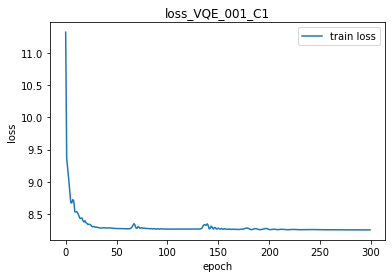

In [26]:
fig = plt.figure()
plt.plot([x for x in range(0,len(ls_progres))],np.array(ls_progres),label="train loss")


plt.legend()
plt.title("loss_VQE_001_C1",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("last loss:",ls_progres[-1])

accuracy loss: 0.14705882352941177


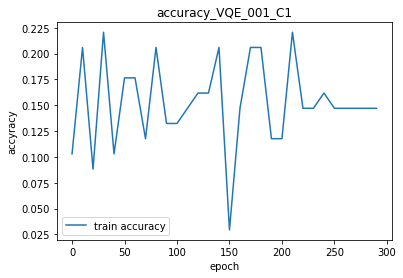

In [27]:
fig = plt.figure()
plt.plot([x for x in range(0,len(ac_progres)*10,10)],np.array(ac_progres),label="train accuracy")


plt.legend()
plt.title("accuracy_VQE_001_C1",)
plt.xlabel("epoch")
plt.ylabel("accyracy")

print("accuracy loss:",ac_progres[-1])

In [28]:
for i in range(len(x)):
    
    words_vec = [parameterize_vovabulary[w] for w in x[i]]
    pred_vector=[ next_gen(params,words_vec, obs=o) for o in ['x', 'y', 'z']]
    pred_word= get_word_from_sphere(pred_vector, parameterize_vovabulary)
    
    text=""
    for w in x[i];
    text=text+w+" "
    
    print("{} {}|{}".format(text, pred_word,y[i]))

SyntaxError: invalid syntax (3275611625.py, line 8)